# 加载必要的库
导入 pandas、matplotlib 和其他必要的库。

In [1]:
# 导入必要的库
import pandas as pd  # 用于数据处理
import matplotlib.pyplot as plt  # 用于数据可视化
import json  # 用于处理 JSON 数据

# 配置 matplotlib 的显示风格
plt.style.use('ggplot')  # 使用 seaborn 风格的图表

# 读取 JSONL 文件
使用 pandas 读取指定路径的 JSONL 文件，并加载为 DataFrame。

In [2]:
# 读取 JSONL 文件
#file_path = "/root/siton-data-0553377b2d664236bad5b5d0ba8aa419/workspace/GainRAG/GainRAG/data/without_pse_nq_train_selector_softmax_combined.jsonl"
file_path = "/root/siton-data-0553377b2d664236bad5b5d0ba8aa419/workspace/GainRAG/GainRAG/data/with_reason_nq_train_selector_debug_data.jsonl"


# 使用 pandas 读取 JSONL 文件
data = pd.read_json(file_path, lines=True)

# 显示前几行数据以确认加载成功
data.head()

,query,num_passages,has_reason_scores,debug_info
0,who sang waiting for a girl like you,21,True,"{'has_reason_scores': True, 'ppl_original': [1..."
1,where do you cross the arctic circle in norway,21,True,"{'has_reason_scores': True, 'ppl_original': [1..."
2,who is the main character in green eggs and ham,21,True,"{'has_reason_scores': True, 'ppl_original': [1..."
3,when does season 5 of bates motel come out,21,True,"{'has_reason_scores': True, 'ppl_original': [1..."
4,how many episodes are in series 7 game of thrones,21,True,"{'has_reason_scores': True, 'ppl_original': [1..."


# 可视化分数分布


Visualizing Record Index: 0


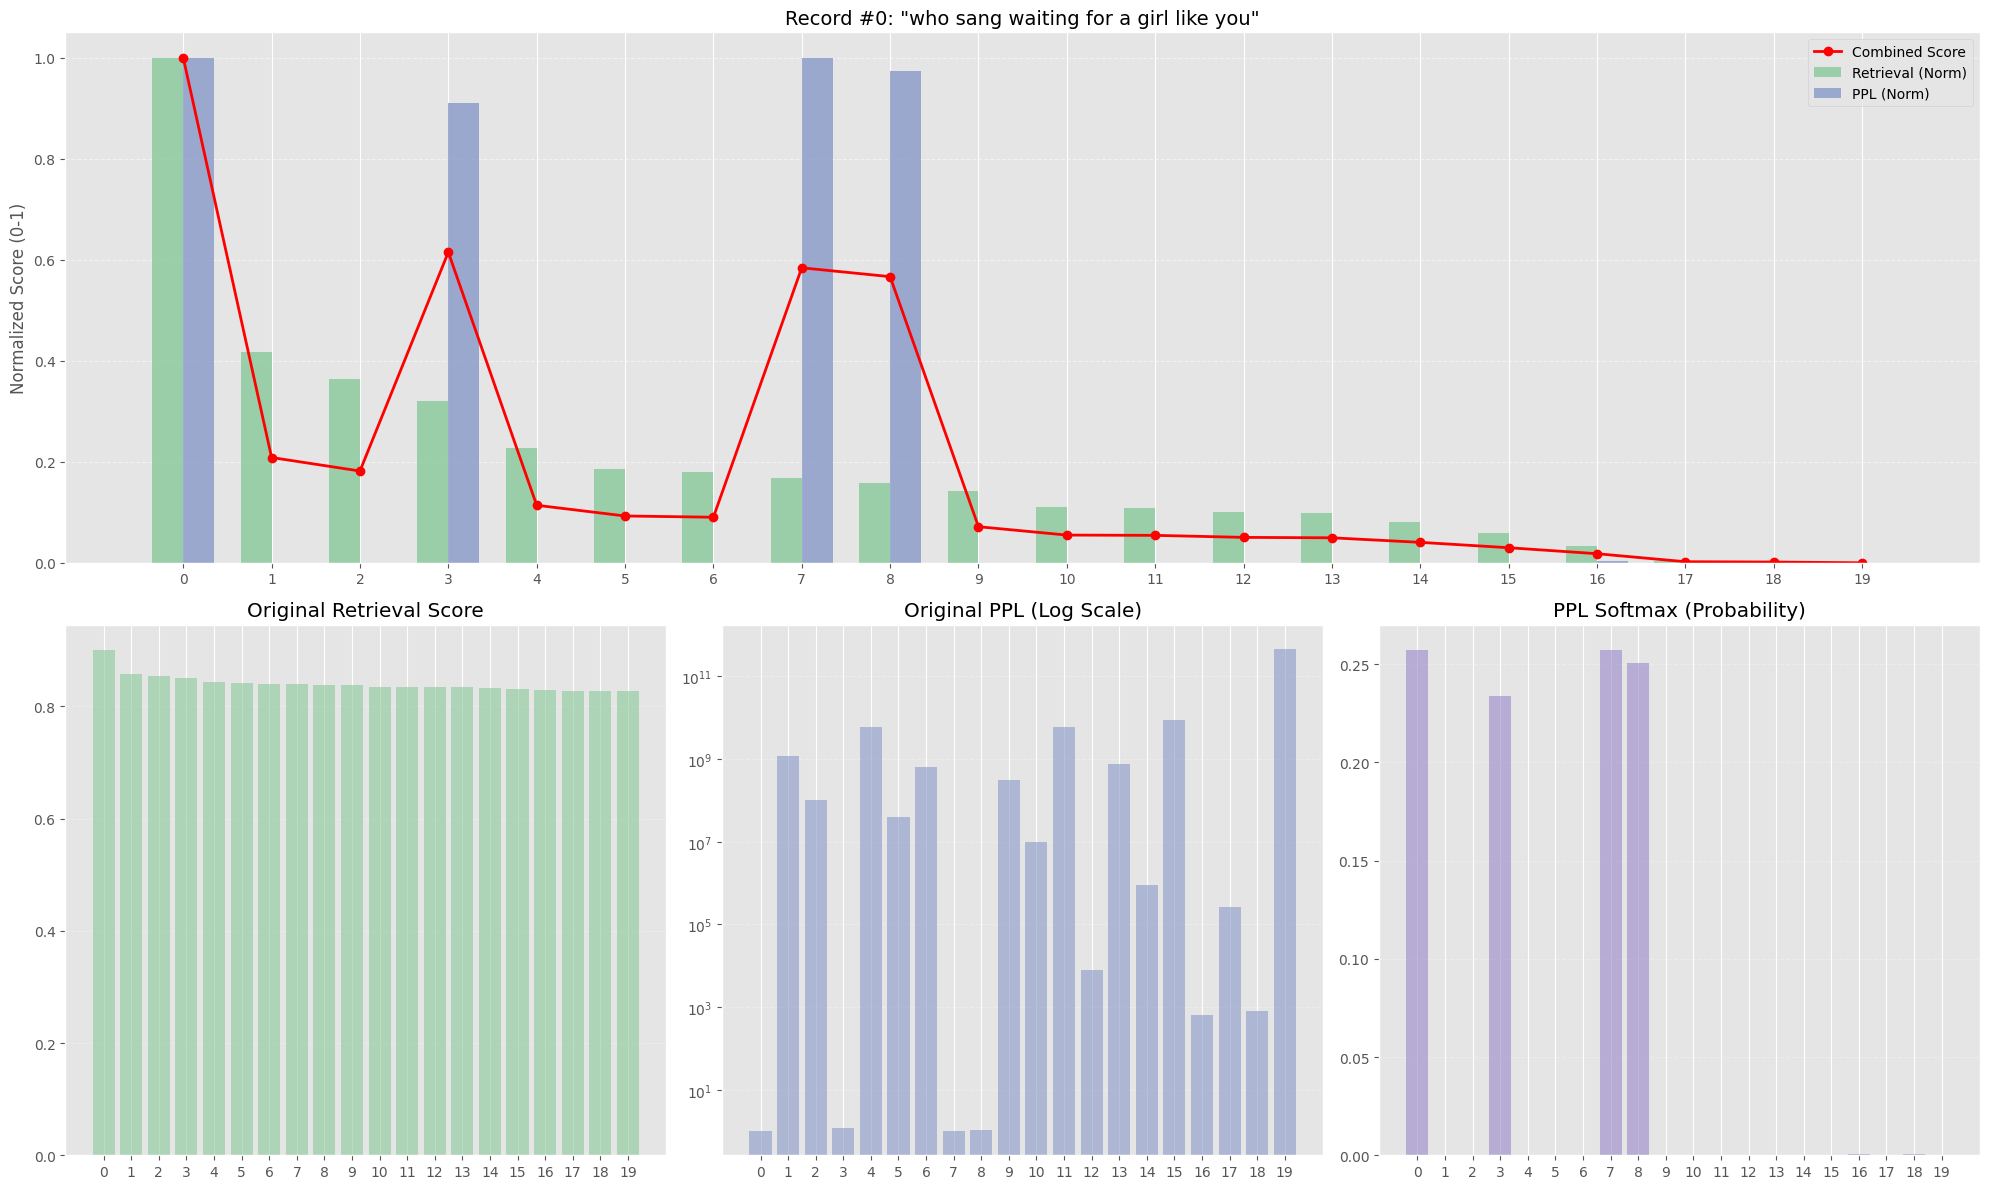

Visualizing Record Index: 1


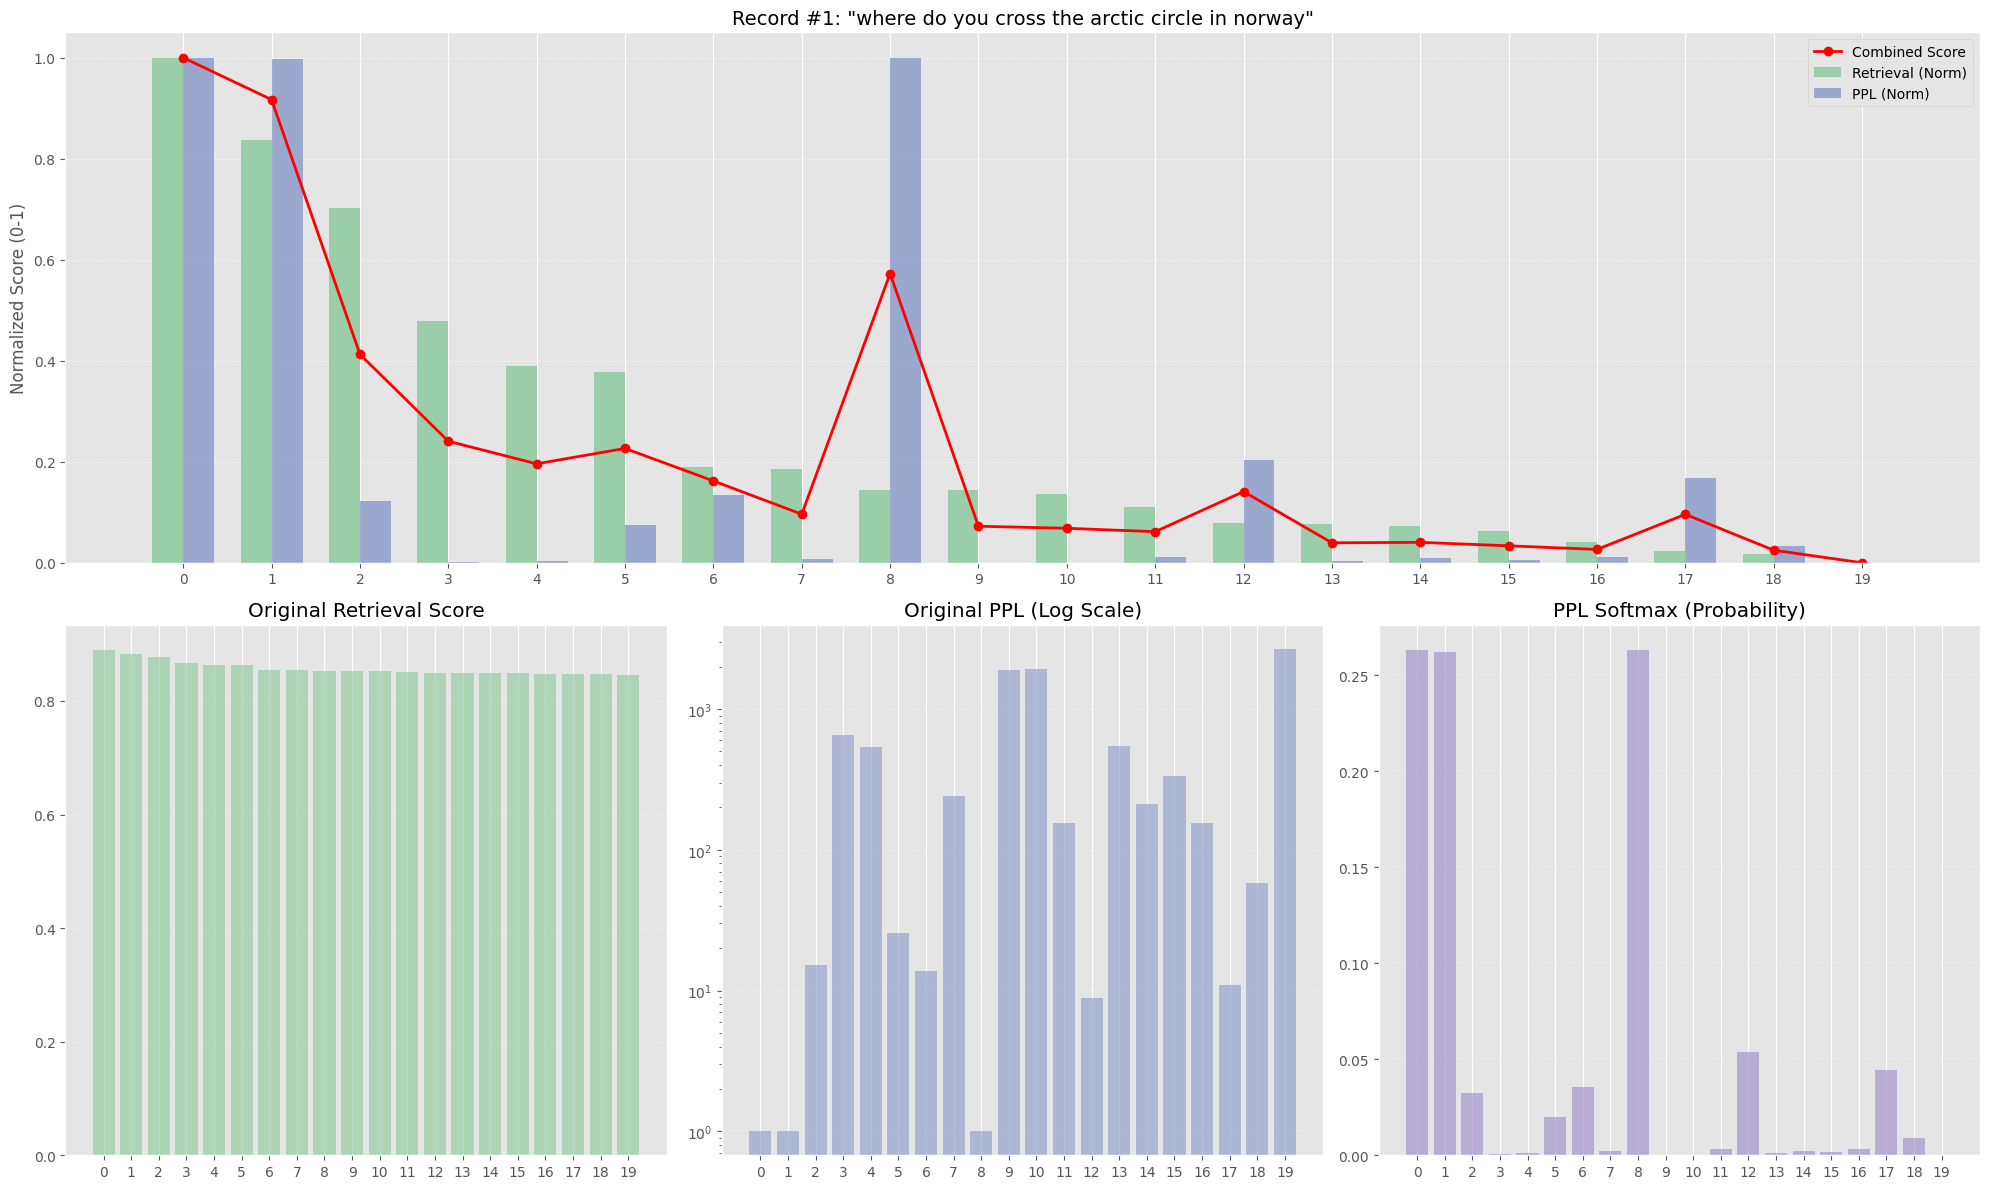

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import json

# 1. 配置：指定要可视化的数据行号 (从0开始)
# 例如: [0] 只看第一条，[0, 5, 10] 看第1、6、11条， range(0, 3) 看前3条
indices_to_visualize = [0, 1] 
file_path = '/root/siton-data-0553377b2d664236bad5b5d0ba8aa419/workspace/GainRAG/GainRAG/data/without_pse_nq_train_selector_debug_data.jsonl'

def plot_record(record, index):
    """封装绘图逻辑"""
    # 提取 debug_info
    if "debug_info" in record:
        data = record["debug_info"]
    else:
        print(f"Warning: 'debug_info' not found in record {index}.")
        data = record

    if not data:
        return

    # 提取数据
    combined = data.get('combined_scores', [])
    passages = np.arange(len(combined))
    
    # 归一化分数
    retrieval = data.get('retrieval_normalized', [])
    ppl = data.get('ppl_normalized', [])
    reason = data.get('reason_normalized', [])
    
    # 原始分数 & 中间分数
    retrieval_orig = data.get('retrieval_original', [])
    ppl_orig = data.get('ppl_original', [])
    ppl_softmax = data.get('ppl_softmax', [])
    reason_orig = data.get('reason_original', [])

    # 判断是否有 reason 数据
    has_reason = len(reason) == len(passages) and len(reason) > 0

    # --- 设置绘图布局 ---
    bottom_cols = 4 if has_reason else 3
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, bottom_cols)

    # ==========================================
    # 第一行: 归一化分数与组合分数
    # ==========================================
    ax_norm = fig.add_subplot(gs[0, :])
    
    if has_reason:
        bar_width = 0.25
        offset_retrieval = -bar_width
        offset_ppl = 0
        offset_reason = bar_width
    else:
        bar_width = 0.35
        offset_retrieval = -bar_width/2
        offset_ppl = bar_width/2
        offset_reason = 0

    if len(retrieval) == len(passages):
        ax_norm.bar(passages + offset_retrieval, retrieval, width=bar_width, label='Retrieval (Norm)', color='#88c999', alpha=0.8)
    if len(ppl) == len(passages):
        ax_norm.bar(passages + offset_ppl, ppl, width=bar_width, label='PPL (Norm)', color='#8899c9', alpha=0.8)
    if has_reason:
        ax_norm.bar(passages + offset_reason, reason, width=bar_width, label='Reason (Norm)', color='#c98888', alpha=0.8)
    if len(combined) > 0:
        ax_norm.plot(passages, combined, label='Combined Score', color='red', linewidth=2, marker='o', linestyle='-')

    query_text = record.get('query', 'Unknown Query')
    ax_norm.set_title(f'Record #{index}: "{query_text}"', fontsize=14)
    ax_norm.set_ylabel('Normalized Score (0-1)')
    ax_norm.set_xticks(passages)
    ax_norm.legend(loc='upper right')
    ax_norm.grid(axis='y', linestyle='--', alpha=0.5)

    # ==========================================
    # 第二行: 原始分数与中间分数
    # ==========================================
    # 2.1 Retrieval Original
    ax_ret_orig = fig.add_subplot(gs[1, 0])
    if len(retrieval_orig) == len(passages):
        ax_ret_orig.bar(passages, retrieval_orig, color='#88c999', alpha=0.6)
        ax_ret_orig.set_title('Original Retrieval Score')
        ax_ret_orig.set_xticks(passages)
        ax_ret_orig.grid(axis='y', linestyle='--', alpha=0.3)

    # 2.2 PPL Original (Log Scale)
    ax_ppl_orig = fig.add_subplot(gs[1, 1])
    if len(ppl_orig) == len(passages):
        ax_ppl_orig.bar(passages, ppl_orig, color='#8899c9', alpha=0.6)
        ax_ppl_orig.set_title('Original PPL (Log Scale)')
        ax_ppl_orig.set_yscale('log') 
        ax_ppl_orig.set_xticks(passages)
        ax_ppl_orig.grid(axis='y', linestyle='--', alpha=0.3)

    # 2.3 PPL Softmax
    ax_ppl_soft = fig.add_subplot(gs[1, 2])
    if len(ppl_softmax) == len(passages):
        ax_ppl_soft.bar(passages, ppl_softmax, color='#9988c9', alpha=0.6)
        ax_ppl_soft.set_title('PPL Softmax (Probability)')
        ax_ppl_soft.set_xticks(passages)
        ax_ppl_soft.grid(axis='y', linestyle='--', alpha=0.3)

    # 2.4 Reason Original (如果有)
    if has_reason:
        ax_reason_orig = fig.add_subplot(gs[1, 3])
        if len(reason_orig) == len(passages):
            ax_reason_orig.bar(passages, reason_orig, color='#c98888', alpha=0.6)
            ax_reason_orig.set_title('Original Reason Score')
            ax_reason_orig.set_xticks(passages)
            ax_reason_orig.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# 2. 读取文件并处理指定行
try:
    target_indices_set = set(indices_to_visualize)
    max_index = max(target_indices_set) if target_indices_set else -1
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i in target_indices_set:
                try:
                    record = json.loads(line)
                    print(f"Visualizing Record Index: {i}")
                    plot_record(record, i)
                except json.JSONDecodeError:
                    print(f"Error decoding JSON at line {i}")
            
            # 如果已经处理完所有需要的行，提前退出循环
            if i >= max_index:
                break
                
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

## 训练过程分析

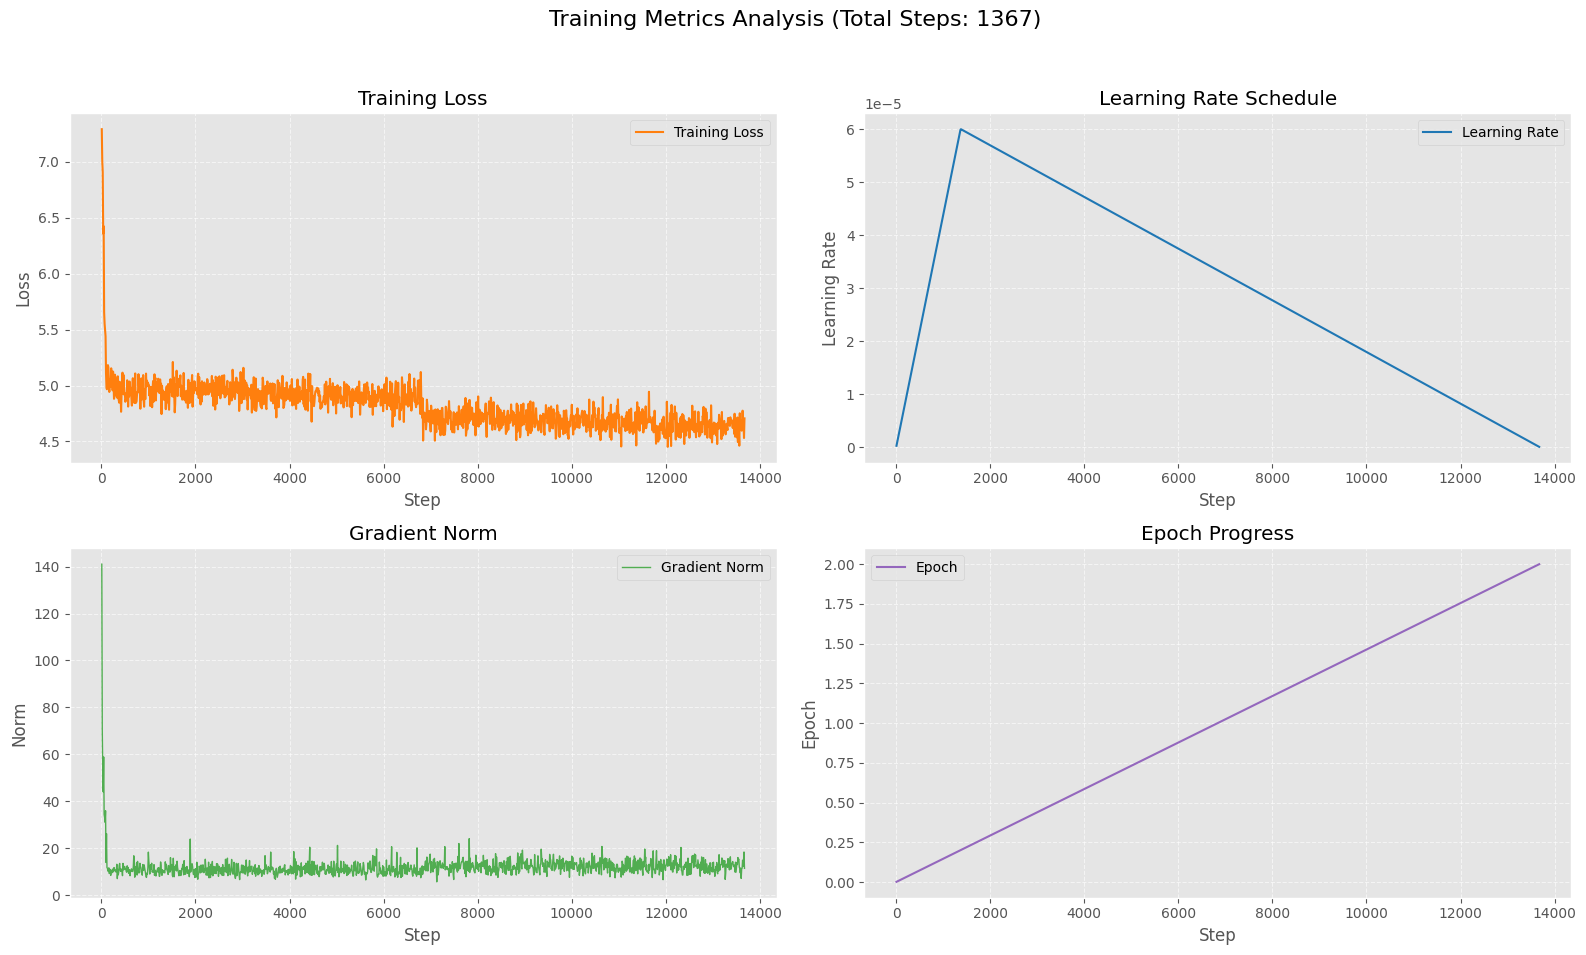

Total Logged Steps: 1367
Min Loss: 4.4522
Final Loss: 4.7068


In [11]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# 1. 配置：指定 trainer_state.json 的路径
#file_path = '/root/siton-data-0553377b2d664236bad5b5d0ba8aa419/workspace/GainRAG/GainRAG/gainRAG/model_outputs/test_grpo4/--overwrite_output_dir/checkpoint-3492/trainer_state.json'  # 请替换为你的实际路径
file_path = "/root/siton-tmp/model_outputs/without_pse_gain_reranker/checkpoint-13674/trainer_state.json"
def visualize_training(json_path):
    try:
        # 读取 JSON 文件
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # 提取 log_history
        history = data.get('log_history', [])
        
        if not history:
            print("Error: 'log_history' is empty or not found.")
            return

        # 将数据转换为 DataFrame 以便处理
        df = pd.DataFrame(history)
        
        # 过滤掉没有 'loss' 或 'step' 的行 (有些 log 可能是 eval 结果)
        if 'loss' in df.columns:
            df_train = df.dropna(subset=['loss', 'step'])
        else:
            print("Error: No 'loss' data found in log_history.")
            return

        # 确保数据按 step 排序
        df_train = df_train.sort_values('step')

        # --- 开始绘图 ---
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle(f'Training Metrics Analysis (Total Steps: {len(df_train)})', fontsize=16)

        # 1. Loss Curve
        axes[0, 0].plot(df_train['step'], df_train['loss'], label='Training Loss', color='#ff7f0e', linewidth=1.5)
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].set_xlabel('Step')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].grid(True, linestyle='--', alpha=0.6)
        axes[0, 0].legend()

        # 2. Learning Rate Curve
        if 'learning_rate' in df_train.columns:
            axes[0, 1].plot(df_train['step'], df_train['learning_rate'], label='Learning Rate', color='#1f77b4', linewidth=1.5)
            axes[0, 1].set_title('Learning Rate Schedule')
            axes[0, 1].set_xlabel('Step')
            axes[0, 1].set_ylabel('Learning Rate')
            axes[0, 1].grid(True, linestyle='--', alpha=0.6)
            axes[0, 1].legend()
        
        # 3. Gradient Norm Curve
        if 'grad_norm' in df_train.columns:
            axes[1, 0].plot(df_train['step'], df_train['grad_norm'], label='Gradient Norm', color='#2ca02c', linewidth=1, alpha=0.8)
            axes[1, 0].set_title('Gradient Norm')
            axes[1, 0].set_xlabel('Step')
            axes[1, 0].set_ylabel('Norm')
            axes[1, 0].grid(True, linestyle='--', alpha=0.6)
            axes[1, 0].legend()

        # 4. Epoch Progress
        if 'epoch' in df_train.columns:
            axes[1, 1].plot(df_train['step'], df_train['epoch'], label='Epoch', color='#9467bd', linewidth=1.5)
            axes[1, 1].set_title('Epoch Progress')
            axes[1, 1].set_xlabel('Step')
            axes[1, 1].set_ylabel('Epoch')
            axes[1, 1].grid(True, linestyle='--', alpha=0.6)
            axes[1, 1].legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 调整布局以适应总标题
        plt.show()

        # 打印一些统计信息
        print(f"Total Logged Steps: {len(df_train)}")
        print(f"Min Loss: {df_train['loss'].min():.4f}")
        print(f"Final Loss: {df_train['loss'].iloc[-1]:.4f}")

    except FileNotFoundError:
        print(f"Error: File not found at {json_path}")
    except json.JSONDecodeError:
        print(f"Error: Failed to decode JSON from {json_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# 运行可视化
visualize_training(file_path)

## reranker 输出分数分析

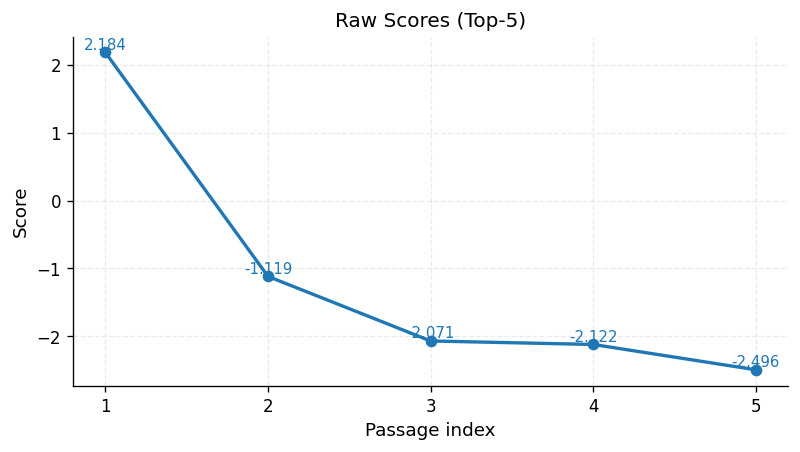

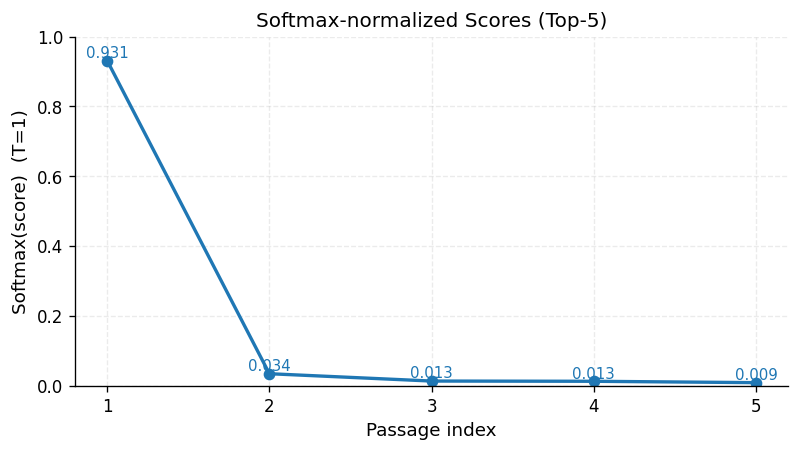

query: which mode is used for short wave broadcast service


In [4]:
# analyse_reranker.py
# %%
from __future__ import annotations

import json
import math
from pathlib import Path
from typing import Any, List, Optional, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt


def _is_finite_number(x: Any) -> bool:
    return isinstance(x, (int, float)) and math.isfinite(x)


def _set_science_style() -> None:
    mpl.rcParams.update(
        {
            "figure.dpi": 120,
            "savefig.dpi": 300,
            "font.size": 11,
            "axes.titlesize": 12,
            "axes.labelsize": 11,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.grid": True,
            "grid.linestyle": "--",
            "grid.alpha": 0.25,
            "axes.axisbelow": True,
        }
    )


def _softmax(xs: List[float], temperature: float = 1.0) -> List[float]:
    if not xs:
        return []
    if temperature <= 0:
        raise ValueError("temperature 必须 > 0")
    m = max(xs)
    exps = [math.exp((x - m) / temperature) for x in xs]
    s = sum(exps)
    return [e / s for e in exps] if s != 0 else [1.0 / len(xs) for _ in xs]


def _get_query_by_index(data: dict, query_index: int) -> str:
    if query_index < 0:
        raise ValueError("query_index 必须 >= 0")
    keys = list(data.keys())
    if query_index >= len(keys):
        raise IndexError(f"query_index 超出范围：{query_index} >= {len(keys)}")
    return keys[query_index]


def plot_raw_and_softmax_scores_by_query_index(
    cache_path: str | Path,
    query_index: int = 0,
    k: int = 5,
    temperature: float = 1.0,
    save_dir: Optional[str | Path] = None,
) -> Tuple[str, List[float], List[float]]:
    """
    选择第 query_index 条 query（按 JSON 顺序），绘制两张图：
    1) 原始 raw scores (Top-k)
    2) softmax(raw scores) (Top-k)

    返回：(query, raw_topk_scores, softmax_topk_scores)
    """
    _set_science_style()

    cache_path = Path(cache_path)
    data = json.loads(cache_path.read_text(encoding="utf-8"))

    query = _get_query_by_index(data, query_index)

    raw_scores: List[float] = []
    items = data.get(query, [])
    if isinstance(items, list):
        for obj in items:
            if isinstance(obj, dict) and _is_finite_number(obj.get("score")):
                raw_scores.append(float(obj["score"]))

    raw_scores = raw_scores[:k]
    if len(raw_scores) < k:
        raise ValueError(f"第{query_index}条 query 的可用 score 数量不足 k={k}（当前={len(raw_scores)}）。")

    probs = _softmax(raw_scores, temperature=temperature)
    x = list(range(1, k + 1))
    color = "#1f77b4"

    # --- 图1：原始分数 ---
    fig1, ax1 = plt.subplots(1, 1, figsize=(6.8, 3.9))
    ax1.plot(x, raw_scores, marker="o", linewidth=2.0, color=color)
    ax1.set_title(f"Raw Scores (Top-{k})")
    ax1.set_xlabel("Passage index")
    ax1.set_ylabel("Score")
    ax1.set_xticks(x)
    for xi, yi in zip(x, raw_scores):
        ax1.text(xi, yi, f"{yi:.3f}", ha="center", va="bottom", fontsize=9, color=color)
    fig1.tight_layout()

    # --- 图2：Softmax 分数 ---
    fig2, ax2 = plt.subplots(1, 1, figsize=(6.8, 3.9))
    ax2.plot(x, probs, marker="o", linewidth=2.0, color=color)
    ax2.set_title(f"Softmax-normalized Scores (Top-{k})")
    ax2.set_xlabel("Passage index")
    ax2.set_ylabel(f"Softmax(score)  (T={temperature:g})")
    ax2.set_xticks(x)
    ax2.set_ylim(0, 1)
    for xi, yi in zip(x, probs):
        ax2.text(xi, yi, f"{yi:.3f}", ha="center", va="bottom", fontsize=9, color=color)
    fig2.tight_layout()

    # 保存（可选）
    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        fig1.savefig(save_dir / f"q{query_index:04d}_raw_top{k}.png", bbox_inches="tight")
        fig2.savefig(save_dir / f"q{query_index:04d}_softmax_top{k}.png", bbox_inches="tight")

    # Jupyter 显示
    plt.show()

    # 返回：方便在 notebook 里打印/校验
    return query, raw_scores, probs
cacahe_path = "/root/siton-data-0553377b2d664236bad5b5d0ba8aa419/workspace/RADIO/output/nq_2025_09_23_10_48_experiment_naive/retrieval_cache.json"
cacahe_path_grpo="/root/siton-data-0553377b2d664236bad5b5d0ba8aa419/workspace/GainRAG/GainRAG/gainRAG/output/nq_2025_12_19_10_43_experiment/retrieval_cache.json"

# Jupyter 示例（按第几条 query 来画）
query, raw_topk, softmax_topk = plot_raw_and_softmax_scores_by_query_index(
    cache_path=cacahe_path_grpo,
    query_index=2,   # 改这里：第几条 query（从 0 开始）
    k=5,
    temperature=1.0,
    save_dir="output",
)
print("query:", query)
# %%